# Car price prediction - Modeling
_Cong Tung Nguyen (May 2021)_ 
<br>
----

In this section, I will try out several regression models, after the additional data preparation. 

### 1. Importing the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### 2. Importing the dataset

In [2]:
cars_df_cleaned = pd.read_pickle('./dataset/cars_df_cleaned.pkl')

In [3]:
df_model = pd.read_pickle('./dataset/df_model.pkl')

In [4]:
cars_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 0 to 359
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Full_Name          350 non-null    object 
 1   Brand              350 non-null    object 
 2   Price (HUF)        350 non-null    int64  
 3   Year               350 non-null    object 
 4   Condition          350 non-null    object 
 5   Design             350 non-null    object 
 6   Kilometers         350 non-null    int64  
 7   Persons            349 non-null    float64
 8   Doors              349 non-null    float64
 9   Colour             299 non-null    object 
 10  Own_weight (kg)    347 non-null    float64
 11  Full_weight (kg)   347 non-null    float64
 12  Trunk (liter)      344 non-null    float64
 13  AirCon_Type        347 non-null    object 
 14  Fuel               350 non-null    object 
 15  Cylinder (cm3)     346 non-null    float64
 16  Layout             342 non

We are going to exclude the imbalance columns, because our dataset is very small.
Having just a few rows of data for one class degrades model quality. If possible, we should have at least 100 rows of data for every class.

We are also going to exclude the columns which have at least a moderate correlation with the other variables, such as weight.

In [4]:
# Choose relevant columns
df_model = cars_df_cleaned[['Brand','Year','Condition','Design','Kilometers','Trunk (liter)','AirCon_Type_short','Fuel','Cylinder (cm3)','Gearbox_short','Power (kW)','HorsePower (hp)','Price (HUF)']]

In [5]:
df_model.head()

,Brand,Year,Condition,Design,Kilometers,Trunk (liter),AirCon_Type_short,Fuel,Cylinder (cm3),Gearbox_short,Power (kW),HorsePower (hp),Price (HUF)
0,RENAULT,2011,Újszerű,Kombi,231000,491.0,Digitális,Dízel,1461.0,Manuális,66,90,1488000
1,MAZDA,2012,Normál,Ferdehátú,188000,NaN,Manuális,Dízel,1560.0,Manuális,70,95,1490000
2,OPEL,2014,Megkímélt,Ferdehátú,199000,285.0,Automata,Benzin,1229.0,Manuális,63,86,1499000
3,FIAT,2012,Normál,Ferdehátú,108260,275.0,Manuális,Benzin,1368.0,Manuális,57,77,1499999
4,FIAT,2011,Normál,Egyterű,188000,NaN,Manuális,Benzin,1400.0,Manuális,70,95,1515000


In [18]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 0 to 359
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              350 non-null    object 
 1   Year               350 non-null    object 
 2   Condition          350 non-null    object 
 3   Design             350 non-null    object 
 4   Kilometers         350 non-null    int64  
 5   Trunk (liter)      344 non-null    float64
 6   AirCon_Type_short  350 non-null    object 
 7   Fuel               350 non-null    object 
 8   Cylinder (cm3)     346 non-null    float64
 9   Gearbox_short      345 non-null    object 
 10  Power (kW)         350 non-null    int64  
 11  HorsePower (hp)    350 non-null    int64  
 12  Price (HUF)        350 non-null    int64  
dtypes: float64(2), int64(4), object(7)
memory usage: 38.3+ KB


### 3. Handling missing values
We are going to use a regression model (random forest regression) to predict the missing numerical values.

For the categorical ones, we are going to replace the null values with the most common value

### a) Categorical variables

In [17]:
most_common_val = df_model['AirCon_Type_short'].value_counts().sort_values(ascending = False).index[0]
df_model['AirCon_Type_short'].fillna(value = most_common_val, inplace=True)

most_common_val_gb = df_model['Gearbox_short'].value_counts().sort_values(ascending = False).index[0]
df_model['Gearbox_short'].fillna(value = most_common_val_gb, inplace=True)

C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


### b) Numerical variables

The dependent variables are going to be the ones, where the missing values are existed. We are going to use the whole dataset, which contains non-missing values, as our training dataset. With the final model we are going to predict the missing values.

In [70]:
# One hot encoding, drop first = True, to avoid dummy variable trap
df_model_dummies = pd.get_dummies(df_model, drop_first=True)

In [71]:
df_model_dummies

,Kilometers,Trunk (liter),Cylinder (cm3),Power (kW),HorsePower (hp),Price (HUF),Brand_AUDI,Brand_BMW,Brand_CHEVROLET,Brand_CITROEN,Brand_DACIA,Brand_FIAT,Brand_FORD,Brand_HONDA,Brand_HYUNDAI,Brand_KIA,Brand_MAZDA,Brand_MERCEDES-BENZ,Brand_MINI,Brand_MITSUBISHI,Brand_NISSAN,Brand_OPEL,Brand_PEUGEOT,Brand_RENAULT,Brand_SEAT,Brand_SKODA,Brand_SMART,Brand_SUZUKI,Brand_TOYOTA,Brand_VOLKSWAGEN,Brand_VOLVO,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Condition_Megkímélt,Condition_Normál,Condition_Sérülésmentes,Condition_Újszerű,Design_Egyterű,Design_Ferdehátú,Design_Kisbusz,Design_Kombi,Design_Sedan,Design_Városi terepjáró (crossover),AirCon_Type_short_Digitális,AirCon_Type_short_Manuális,Fuel_Dízel,Fuel_Elektromos,Fuel_Hibrid,Fuel_Hibrid (Dízel),Gearbox_short_Manuális,Gearbox_short_Szekvenciális
0,231000,491.0,1461.0,66,90,1488000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0
1,188000,NaN,1560.0,70,95,1490000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0
2,199000,285.0,1229.0,63,86,1499000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,108260,275.0,1368.0,57,77,1499999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
4,188000,NaN,1400.0,70,95,1515000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
5,176028,430.0,1198.0,51,69,1550000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
6,190000,480.0,1197.0,63,86,1590000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
7,347310,550.0,1598.0,66,90,1590000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0
8,206000,482.0,1596.0,74,101,1599000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
9,247000,140.0,1686.0,81,110,1599000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


#### Trunk variable

In [72]:
# Test set --> This will be predicted. Training set --> where ['Trunk (liter)'] not isnull()
df_train_temp = df_model_dummies.loc[~df_model_dummies['Trunk (liter)'].isnull()]
df_test_temp = df_model_dummies.loc[df_model_dummies['Trunk (liter)'].isnull()]

In [82]:
# Get the dependent and independent variable columns
train_cols = [x for x in df_train_temp.columns if x != 'Trunk (liter)' and x != 'Cylinder (cm3)']
test_col = 'Trunk (liter)'

In [84]:
# Training - Test set
X_train = np.array(df_train_temp[train_cols])
y_train = np.array(df_train_temp[test_col])
X_test = np.array(df_test_temp[train_cols])
y_test = np.array(df_test_temp[test_col])

In [85]:
# Grid search for hyperparameter tuning
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': np.arange(100,500,50)
}
# Create Random Forest Model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2)

In [86]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  4.2min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450])},
             verbose=2)

In [96]:
# Predict the missing values
trunk_pred = grid_search.predict(X_test)

In [99]:
# Replace the missing values with the predicted values
df_model.loc[df_model['Trunk (liter)'].isnull(),'Trunk (liter)'] = trunk_pred

C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


#### Cylinder variable

In [119]:
df_model_dummies = pd.get_dummies(df_model, drop_first=True)

In [120]:
# Test set --> This will be predicted. Training set --> where ['Cylinder (cm3)'] not isnull()
df_train_temp = df_model_dummies.loc[~df_model_dummies['Cylinder (cm3)'].isnull()]
df_test_temp = df_model_dummies.loc[df_model_dummies['Cylinder (cm3)'].isnull()]

In [122]:
# Get the dependent and independent variable columns
train_cols = [x for x in df_train_temp.columns if x != 'Cylinder (cm3)']
test_col = 'Cylinder (cm3)'

In [123]:
# Training - Test set
X_train = np.array(df_train_temp[train_cols])
y_train = np.array(df_train_temp[test_col])
X_test = np.array(df_test_temp[train_cols])
y_test = np.array(df_test_temp[test_col])

In [124]:
# Grid search for hyperparameter tuning
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': np.arange(100,500,50)
}

# Create Random Forest Model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           cv = 5, n_jobs = -1, verbose = 2)

In [125]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   48.1s
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  4.0min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450])},
             verbose=2)

In [126]:
# Predict the missing values
cylinder_pred = grid_search.predict(X_test)

In [127]:
cylinder_pred

array([1523.89062202, 1485.32068177, 1432.3907544 , 1475.74459447])

In [128]:
# Replace the missing values with the predicted values
df_model.loc[df_model['Cylinder (cm3)'].isnull(),'Cylinder (cm3)'] = cylinder_pred

C:\Users\Asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [6]:
# df_model.to_pickle('./dataset/df_model.pkl')
df_model = pd.read_pickle('./dataset/df_model.pkl')

### 4. Categorical variables encoding - One hot encoding

In [7]:
df_model_dummy = pd.get_dummies(df_model, drop_first=True)

### 5. Splitting the data into a Training and a Test set

In [8]:
df_model_dummy.head(5)

,Kilometers,Trunk (liter),Cylinder (cm3),Power (kW),HorsePower (hp),Price (HUF),Brand_AUDI,Brand_BMW,Brand_CHEVROLET,Brand_CITROEN,Brand_DACIA,Brand_FIAT,Brand_FORD,Brand_HONDA,Brand_HYUNDAI,Brand_KIA,Brand_MAZDA,Brand_MERCEDES-BENZ,Brand_MINI,Brand_MITSUBISHI,Brand_NISSAN,Brand_OPEL,Brand_PEUGEOT,Brand_RENAULT,Brand_SEAT,Brand_SKODA,Brand_SMART,Brand_SUZUKI,Brand_TOYOTA,Brand_VOLKSWAGEN,Brand_VOLVO,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,Year_2017,Year_2018,Year_2019,Condition_Megkímélt,Condition_Normál,Condition_Sérülésmentes,Condition_Újszerű,Design_Egyterű,Design_Ferdehátú,Design_Kisbusz,Design_Kombi,Design_Sedan,Design_Városi terepjáró (crossover),AirCon_Type_short_Digitális,AirCon_Type_short_Manuális,Fuel_Dízel,Fuel_Elektromos,Fuel_Hibrid,Fuel_Hibrid (Dízel),Gearbox_short_Manuális,Gearbox_short_Szekvenciális
0,231000,491.000000,1461.0,66,90,1488000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0
1,188000,393.133732,1560.0,70,95,1490000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0
2,199000,285.000000,1229.0,63,86,1499000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,108260,275.000000,1368.0,57,77,1499999,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
4,188000,374.390041,1400.0,70,95,1515000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


In [9]:
indep_cols = [x for x in df_model_dummy.columns if x != 'Price (HUF)']
dep_col = 'Price (HUF)'

X = np.array(df_model_dummy[indep_cols])
y = np.array(df_model_dummy[dep_col])

80% of the dataset is going to be our training set. 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

### 6. Feature scaling

We are going to use standardization as a feature scaling technique.

Standardization is a scaling technique where the values are centered around the mean with a unit standard deviation. This means that the mean of the attribute becomes zero and the resultant distribution has a unit standard deviation.

In [11]:
sc = StandardScaler()
X_train[:,[0,1,2,3,4]] = sc.fit_transform(X_train[:,[0,1,2,3,4]])
X_test[:,[0,1,2,3,4]] = sc.transform(X_test[:,[0,1,2,3,4]])

In [12]:
# Saving the scaler into a pickle file, because we are going to use it in our flask application later on
pickle.dump(sc, open('./model/scaler.pkl','wb'))

### 7. Model building

#### 7.1. Linear Regression

In [38]:
lr_model = LinearRegression()

In [39]:
lr_model.fit(X_train, y_train)

LinearRegression()

In [44]:
lr_model_r2 = lr_model.score(X_train,y_train)

In [45]:
print('R^2 score: {}'.format(lr_model_r2))

R^2 score: 0.7566759015310365


Linear regression is an analysis that assesses whether one or more predictor variables explain the dependent (criterion) variable. The regression has five key assumptions:

* Linear relationship
* Normality
* No or little multicollinearity
* No auto-correlation
* Homoscedasticity

I will check, whether these assumptions are met in our case.
The function below is from [Jeff Macaluso](https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/) amazing work.

In [57]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable. If not, either a quadratic term or another
               algorithm should be used.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        print()
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')
        
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    # Plotting the heatmap
    plt.figure(figsize = (10,8))
    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

def autocorrelation_assumption(model, features, label):
    """
    Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                     autocorrelation, then there is a pattern that is not explained due to
                     the current value being dependent on the previous value.
                     This may be resolved by adding a lag variable of either the dependent
                     variable or some of the predictors.
    """
    from statsmodels.stats.stattools import durbin_watson
    print('Assumption 4: No Autocorrelation', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = calculate_residuals(model, features, label)

    print('\nPerforming Durbin-Watson Test')
    print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
    print('0 to 2< is positive autocorrelation')
    print('>2 to 4 is negative autocorrelation')
    print('-------------------------------------')
    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
        print('Assumption not satisfied')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
        print('Assumption not satisfied')
    else:
        print('Little to no autocorrelation', '\n')
        print('Assumption satisfied')

def homoscedasticity_assumption(model, features, label):
    """
    Homoscedasticity: Assumes that the errors exhibit constant variance
    """
    print('Assumption 5: Homoscedasticity of Error Terms', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)

    # Plotting the residuals
    plt.subplots(figsize=(12, 6))
    ax = plt.subplot(111)  # To remove spines
    plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
    plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
    ax.spines['right'].set_visible(False)  # Removing the right spine
    ax.spines['top'].set_visible(False)  # Removing the top spine
    plt.title('Residuals')
    plt.show()  

#### Linear realtionship:

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


C:\Users\Asus\anaconda3\lib\site-packages\seaborn\regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


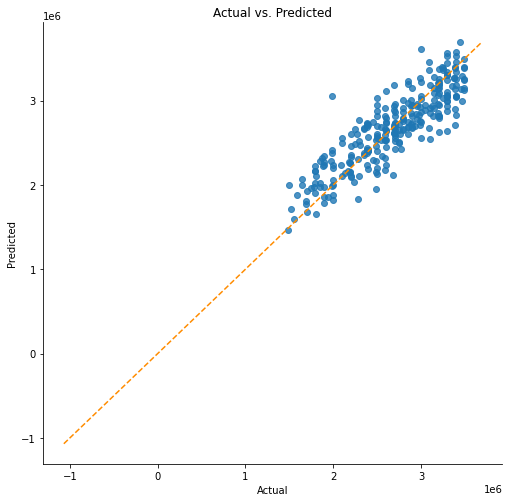

In [50]:
linear_assumption(lr_model,X_train,y_train)

#### Normality of the Error Terms:

Assumption 2: The error terms are normally distributed 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.34040561208436215
Residuals are normally distributed


C:\Users\Asus\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


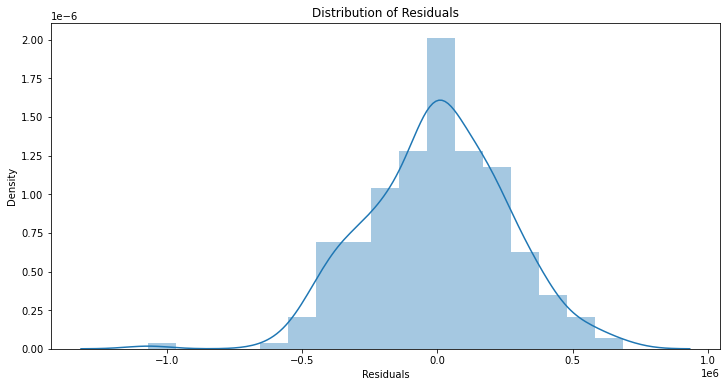


Assumption satisfied


In [52]:
normal_errors_assumption(lr_model, X_train, y_train)

#### No or little Multicollinearity among Predictors

Assumption 3: Little to no multicollinearity among predictors


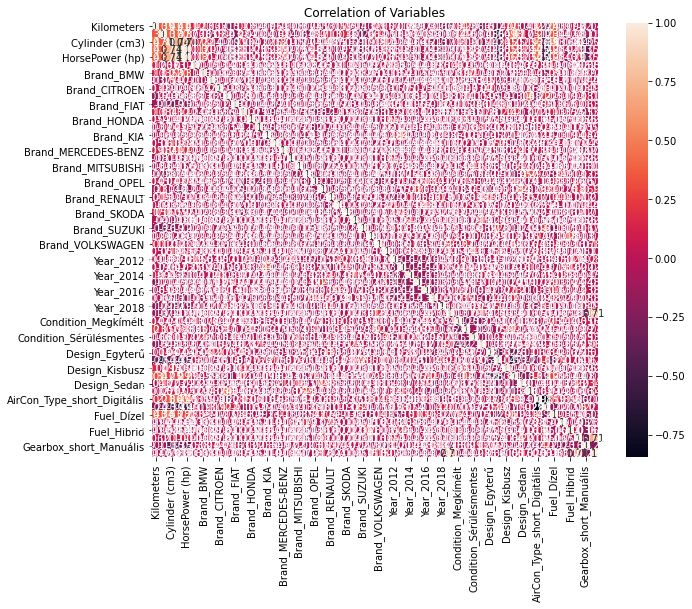

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
Kilometers: 2.1190756058979936
Trunk (liter): 2.521579103153548
Cylinder (cm3): 4.292887558264198
Power (kW): 13886.097817593143
HorsePower (hp): 13912.145086959326
Brand_AUDI: 2.107803082195658
Brand_BMW: 2.6619569265511327
Brand_CHEVROLET: 2.5538061608668388
Brand_CITROEN: 2.266544834341336
Brand_DACIA: 5.961233259992038
Brand_FIAT: 3.2134489203058725
Brand_FORD: 13.697858336072686
Brand_HONDA: 1.3805275912701713
Brand_HYUNDAI: 6.082357052606528
Brand_KIA: 5.84540289255375
Brand_MAZDA: 2.3079992173258583
Brand_MERCEDES-BENZ: 2.0534570611950373
Brand_MINI: 1.432929838692341
Brand_MITSUBISHI: 1.7393205266036775
Brand_NISSAN: 5.240645959364371
Brand_OPEL: 14.779913811922142
Brand_PEUGEOT: 9.228071814160279
Brand_RENAULT: 7.654457004143954
Brand_SEAT: 2.3026718917805953
Brand_SKODA: 4.161602435162946
Brand_SM

C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [54]:
linear_feature_names = [x for x in df_model_dummy.columns if x != 'Price (HUF)']
multicollinearity_assumption(lr_model, X_train, y_train, linear_feature_names)

Unfortunately, our assumption is not satisfied in that case. However, it was not surprising, because we have a lot of dummy variables, and in that case, multicollinearity cannot be avoided.

#### No Autocorrelation of the Error Terms:

In [56]:
autocorrelation_assumption(lr_model, X_train, y_train)

Assumption 4: No Autocorrelation 


Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.9399298407345373
Little to no autocorrelation 

Assumption satisfied


#### Homoscedasticity:

Assumption 5: Homoscedasticity of Error Terms 

Residuals should have relative constant variance


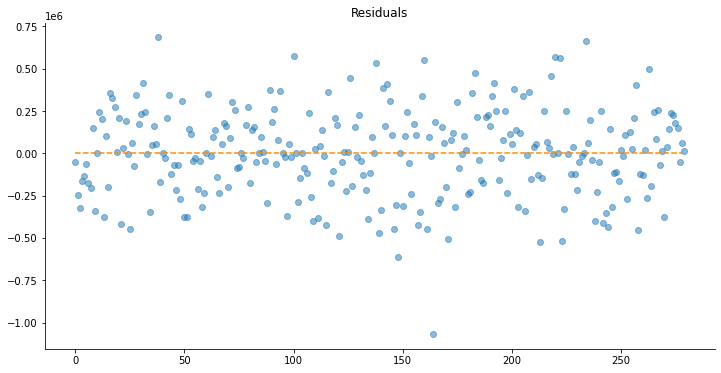

In [58]:
homoscedasticity_assumption(lr_model, X_train, y_train)

Linear Regression prediction:

In [127]:
y_pred = lr_model.predict(X_test)

lr_mae = mean_absolute_error(y_test, y_pred)
lr_mse = mean_squared_error(y_test, y_pred)
lr_rmse = math.sqrt(lr_mse)

print('Mean Absolute Error: {}'.format(lr_mae))
print('Mean Squared Error: {}'.format(lr_mse))
print('Root Mean Squared Error: {}'.format(lr_rmse))

Mean Absolute Error: 239363.36186362963
Mean Squared Error: 86066191988.79105
Root Mean Squared Error: 293370.40066917293


#### 7.2. Support Vector Regression

In [69]:
# Grid search for hyperparameter tuning
svr_model = SVR()

parameters = [{'kernel':('linear','rbf','poly'), 'C':[0.25,0.5,0.75,1], 'epsilon':[0.1,0.2,0.5,0.3]}]

svr_grid_search = GridSearchCV(estimator=svr_model,
                           param_grid=parameters,
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           n_jobs = -1)

In [70]:
svr_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.25, 0.5, 0.75, 1],
                          'epsilon': [0.1, 0.2, 0.5, 0.3],
                          'kernel': ('linear', 'rbf', 'poly')}],
             scoring='neg_root_mean_squared_error')

In [71]:
svr_grid_search.best_params_

{'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}

In [109]:
y_pred = svr_grid_search.predict(X_test)

svr_mae = mean_absolute_error(y_test, y_pred)
svr_mse = mean_squared_error(y_test, y_pred)
svr_rmse = math.sqrt(svr_mse)

print('Mean Absolute Error: {}'.format(svr_mae))
print('Mean Squared Error: {}'.format(svr_mse))
print('Root Mean Squared Error: {}'.format(svr_rmse))

Mean Absolute Error: 449663.0628454621
Mean Squared Error: 312189492810.2065
Root Mean Squared Error: 558739.1992783453


#### 7.3. Random Forest Regression

In [86]:
# Grid search for hyperparameter tuning
rf_model = RandomForestRegressor()

parameters = [{'n_estimators':[20,40,60,80,100,120,140,160,180,200], 
               'criterion':['mse','mae'], 
               'min_samples_leaf': [3, 4, 5],
               'min_samples_split': [8, 10, 12],
              }]

rf_grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=parameters,
                           scoring='neg_root_mean_squared_error',
                           cv=5,
                           n_jobs = -1)

In [87]:
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'criterion': ['mse', 'mae'],
                          'min_samples_leaf': [3, 4, 5],
                          'min_samples_split': [8, 10, 12],
                          'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160,
                                           180, 200]}],
             scoring='neg_root_mean_squared_error')

In [88]:
rf_grid_search.best_params_

{'criterion': 'mae',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 40}

In [110]:
y_pred = rf_grid_search.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred)
rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = math.sqrt(rf_mse)

print('Mean Absolute Error: {}'.format(rf_mae))
print('Mean Squared Error: {}'.format(rf_mse))
print('Root Mean Squared Error: {}'.format(rf_rmse))

Mean Absolute Error: 335055.42178571434
Mean Squared Error: 168962688480.37735
Root Mean Squared Error: 411050.7127841738


#### 7.4. XGBoost

In [92]:
xgb_model = XGBRegressor()

In [93]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [111]:
y_pred = xgb_model.predict(X_test)

xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_mse = mean_squared_error(y_test, y_pred)
xgb_rmse = math.sqrt(xgb_mse)

print('Mean Absolute Error: {}'.format(xgb_mae))
print('Mean Squared Error: {}'.format(xgb_mse))
print('Root Mean Squared Error: {}'.format(xgb_rmse))

Mean Absolute Error: 332011.0553571429
Mean Squared Error: 163648989422.9154
Root Mean Squared Error: 404535.5230667826


### 8. Evaluation

In [129]:
df_eval = pd.DataFrame({'Model':['Multiple Linear Regression','SVR','Random Forest','XGBoost'],
                        'MAE':[lr_mae, svr_mae, rf_mae, xgb_mae],
                        'MSE':[lr_mse,svr_mse, rf_mse, xgb_mse],
                        'RMSE':[lr_rmse, svr_rmse, rf_rmse, xgb_rmse]})

df_eval

,Model,MAE,MSE,RMSE
0,Multiple Linear Regression,239363.361864,8.606619e+10,293370.400669
1,SVR,449663.062845,3.121895e+11,558739.199278
2,Random Forest,335055.421786,1.689627e+11,411050.712784
3,XGBoost,332011.055357,1.636490e+11,404535.523067


Linear Regression has the best accuracy with an R^2 score of approximately 70%, therefore I choose that model in the deployment section. Unfortunately, our dataset is pretty small, and not representative. It is quite hard to find a model which have a good forecasting ability in our case.

In [132]:
# Saving the final model into a pickle file
pickle.dump(lr_model, open('./model/model.pkl','wb'))

# loaded_model = pickle.load(open('./model/model.pkl', 'rb'))